In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mtick
import seaborn as sns
sns.set_theme(style="whitegrid")

from pathlib import Path

import os

In [2]:
state = 'GA'
dist_type = 'SH'

In [3]:
bursts_dir = Path(f'../chains/short_burst_chain_data/{state}_{dist_type}_gingles/20210608')

In [4]:
burst_len = list(bursts_dir.glob('*.csv'))[0].stem.split('_')[3]
num_bursts = list(bursts_dir.glob('*.csv'))[0].stem.split('_')[4]

In [ ]:
bursts_dp_df = pd.read_csv(bursts_dir/f'{state}_{dist_type}_bg_{burst_len}_{num_bursts}_dp_bursts.csv')
bursts_dp_mm_dists = bursts_dp_df.iloc[:,:2]

In [22]:
bursts_data_hues = []
bursts_diffs = sorted((bursts_dp_mm_dists.num_b_seats_dp - bursts_dp_mm_dists.num_b_seats_sf).unique())
for i in bursts_diffs:
    new_df = bursts_dp_mm_dists.copy()
    new_df.loc[:,'diff'] = new_df.num_b_seats_dp - new_df.num_b_seats_sf
    label_data_hues = new_df[new_df['diff'] == i]
    bursts_data_hues.append(label_data_hues)

/tmp/user/19663/ipykernel_2132397/2807598380.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('RdYlBu')
/tmp/user/19663/ipykernel_2132397/2807598380.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])


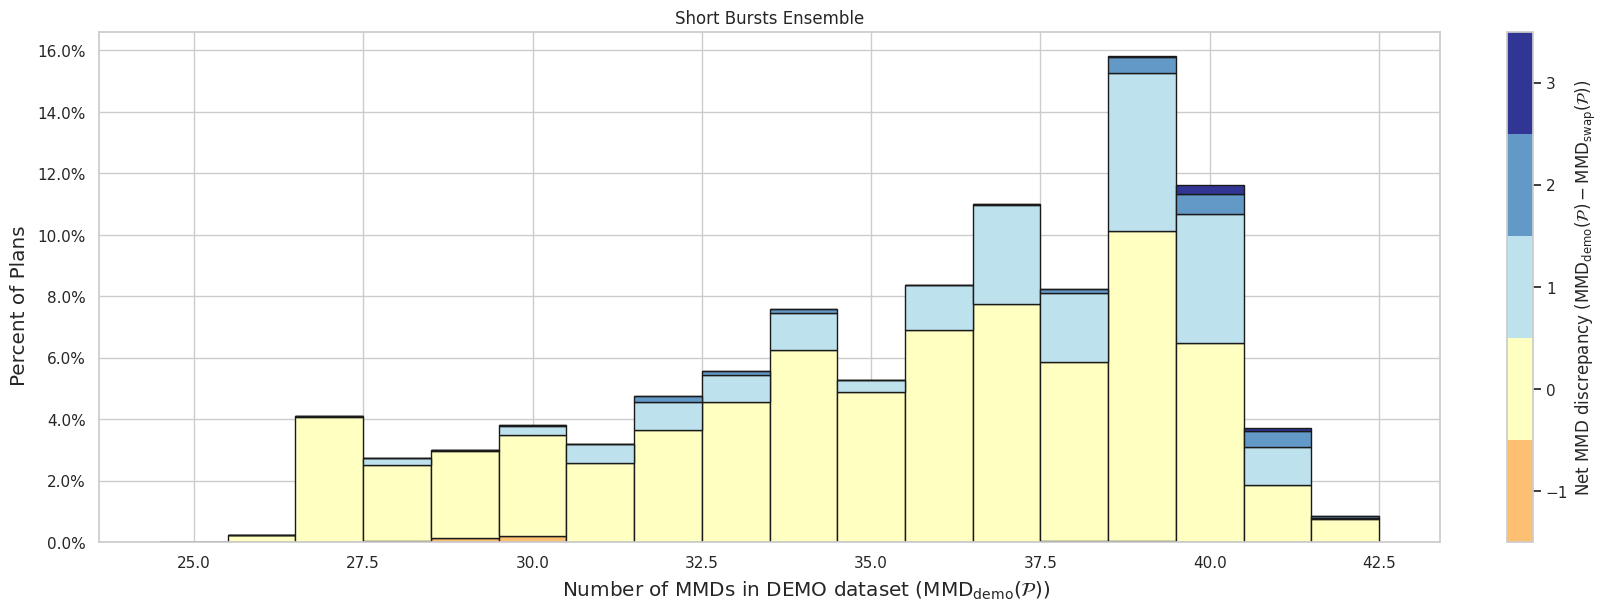

In [21]:
fig, ax = plt.subplots(1,1,figsize=(16,6), sharey=True, constrained_layout=True)
colors = cm.get_cmap('RdYlBu')

bursts_hist_range = range(bursts_dp_mm_dists.min().min(), bursts_dp_mm_dists.max().max()+2)
ax.set_title('Short Bursts Ensemble')
weights = [np.ones(len(x)) / len(bursts_dp_mm_dists) for x in bursts_data_hues]
_,_,patches = ax.hist([x.num_b_seats_dp for x in bursts_data_hues], bins=bursts_hist_range, align='left', stacked=True, weights=weights)#, density=True)

for i,patch in enumerate(patches):
    for j,rect in enumerate(patch):
        rect.set(color=colors((bursts_diffs[i]/max(2*np.abs(bursts_diffs))) + 0.5), edgecolor='k')

# show colorbar
min_bound = -max(bursts_diffs)
min_val = min(bursts_diffs)
max_bound = max(bursts_diffs)
ticks = np.arange(min_bound, max_bound+1)
norm = mpl.colors.Normalize(vmin=min_bound, vmax=max_bound)
bounds = np.arange(min_bound-0.5, max_bound+1.5)
cbar = plt.colorbar(cm.ScalarMappable(cmap=colors, norm=norm), ax=ax, orientation='vertical', boundaries=bounds, ticks=ticks)

cbar.set_ticks(np.arange(-max(bursts_diffs), max(bursts_diffs)+1))
cbar.ax.set_ylim(min(bursts_diffs)-0.5, max(bursts_diffs)+0.5)


fig.supxlabel('Number of MMDs in DEMO dataset ($\mathsf{MMD}_\mathsf{demo}(\mathcal{P})$)')
fig.supylabel('Percent of Plans')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
cbar.ax.set_ylabel('Net MMD discrepancy ($\mathsf{MMD}_\mathsf{demo}(\mathcal{P}) - \mathsf{MMD}_\mathsf{swap}(\mathcal{P})$)')
plt.show()

In [18]:
ndists = bursts_dp_df.filter(regex='NBVAPsf').shape[1]
ndists

180

In [8]:
bursts_dp_dists = []
for i in range(1,ndists+1):
    temp = bursts_dp_df.filter(regex=f'dp_{i}$|sf_{i}$').set_axis(['NBVAPsf', 'NBVAPdp', 'BVAPsf', 'BVAPdp'], axis=1)
    temp = temp.loc[(temp.shift() != temp).any(axis=1)]
    bursts_dp_dists.append(temp)
bursts_dp_dists = pd.concat(bursts_dp_dists)

bursts_dp_dists['MMsf'] = (bursts_dp_dists['BVAPsf'] / (bursts_dp_dists['BVAPsf'] + bursts_dp_dists['NBVAPsf'])) > 0.5
bursts_dp_dists['MMdp'] = (bursts_dp_dists['BVAPdp'] / (bursts_dp_dists['BVAPdp'] + bursts_dp_dists['NBVAPdp'])) > 0.5
bursts_dp_dists['TOTPOPsf'] = bursts_dp_dists['BVAPsf'] + bursts_dp_dists['NBVAPsf']
bursts_dp_dists['TOTPOPdp'] = bursts_dp_dists['BVAPdp'] + bursts_dp_dists['NBVAPdp']
bursts_dp_dists['ADVsf'] = bursts_dp_dists['BVAPsf'] - ((bursts_dp_dists['BVAPsf'] + bursts_dp_dists['NBVAPsf']) // 2)
bursts_dp_dists['ADVdp'] = bursts_dp_dists['BVAPdp'] - ((bursts_dp_dists['BVAPdp'] + bursts_dp_dists['NBVAPdp']) // 2)
bursts_dp_dists['PROPBsf'] = bursts_dp_dists['BVAPsf'] / (bursts_dp_dists['BVAPsf'] + bursts_dp_dists['NBVAPsf'])
bursts_dp_dists['PROPBdp'] = bursts_dp_dists['BVAPdp'] / (bursts_dp_dists['BVAPdp'] + bursts_dp_dists['NBVAPdp'])

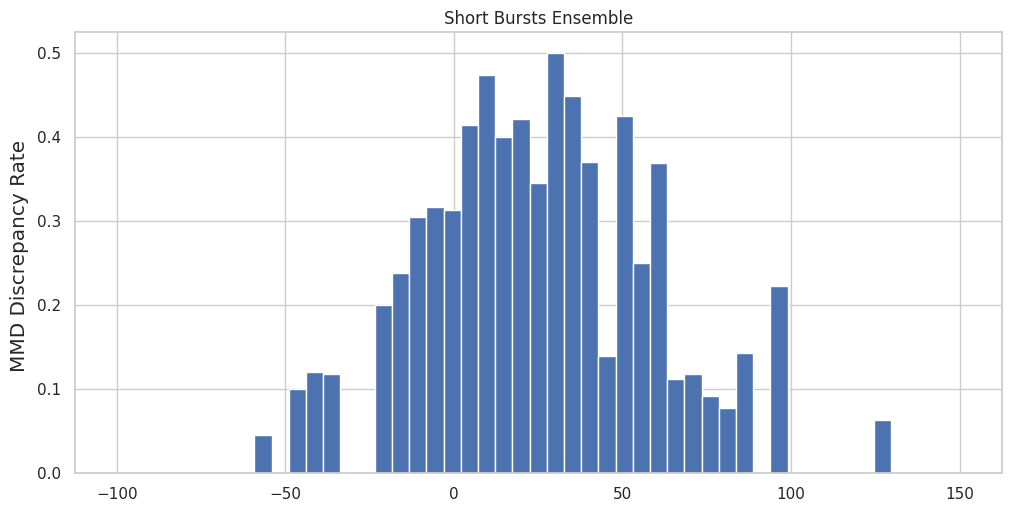

In [12]:
bursts_incorrect = bursts_dp_dists[bursts_dp_dists['MMsf'] != bursts_dp_dists['MMdp']]['ADVdp']
bursts_correct = bursts_dp_dists[bursts_dp_dists['MMsf'] == bursts_dp_dists['MMdp']]['ADVdp']

bins = np.linspace(-100,150,50)

bursts_correct_hist = np.histogram(bursts_correct, bins=bins)
bursts_incorrect_hist = np.histogram(bursts_incorrect, bins=bins)
bursts_prop_hist = bursts_incorrect_hist[0] / (bursts_incorrect_hist[0] + bursts_correct_hist[0])

fig,ax = plt.subplots(1,1,figsize=(10,5), sharex=True, sharey=True, constrained_layout=True)
ax.bar(bins[:-1], bursts_prop_hist, width=bins[1]-bins[0], align='edge')

fig.supylabel('MMD Discrepancy Rate')

ax.set_title('Short Bursts Ensemble')

plt.show()